In [1]:
%matplotlib inline
%config InlineBackend.figure_format = True
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
import astropy.units as u
from astropy.utils.console import ProgressBar

from rms import STSP, Star, Spot

In [5]:
t0 = 2454605.8914
rotation_period = 25

transit_times = Time(t0, format='jd') + np.arange(-3/24, 3/24, 1/30/24) * u.day

sun_with_h11b = Star(rotation_period=rotation_period, planet=True)

In [6]:
n_transits = 1000
fluxes = np.zeros((len(transit_times), n_transits))
times = np.zeros((len(transit_times), n_transits))

no_transit_spot = Spot(radius=0.0001, latitude=-88*u.deg, longitude=0*u.deg)

with ProgressBar(n_transits, ipython_widget=True) as bar:
    for i in range(n_transits):
        
        # Draw spots from the sunspot distribution
        n_spots = 8
        spots = [Spot.from_sunspot_distribution() for i in range(n_spots)]

        # Draw observing times from uniform distribution
        random_times = transit_times + 1 * (np.random.rand() - 0.5) * u.min
        
        with STSP(random_times, sun_with_h11b, spots) as stsp: 
            lc = stsp.generate_lightcurve(n_ld_rings=100)
            
        with STSP(random_times, sun_with_h11b, no_transit_spot) as stsp: 
            no_spot_lc = stsp.generate_lightcurve(n_ld_rings=100)
        
        oot_fluxes = lc.mask_out_of_transit(sun_with_h11b, flip=True)['fluxes']
        median_oot_flux = np.median(oot_fluxes)
        
        fluxes[:, i] = lc.fluxes / median_oot_flux - no_spot_lc.fluxes
        times[:, i] = random_times.jd
        
        bar.update()


Spots tossed:

<Spot: lat=5.944793473607251 deg, lon=0.5147801933345424 rad, rad=0.005317809815456633> [rms.stsp]

Spots tossed:

<Spot: lat=11.879655622964961 deg, lon=3.7933795598309037 rad, rad=0.00678051556194625> [rms.stsp]

Spots tossed:

<Spot: lat=10.989949671447727 deg, lon=5.375790872328859 rad, rad=0.006035168579207301> [rms.stsp]

Spots tossed:

<Spot: lat=4.801564132415251 deg, lon=1.6506637245489422 rad, rad=0.005414342929525535> [rms.stsp]


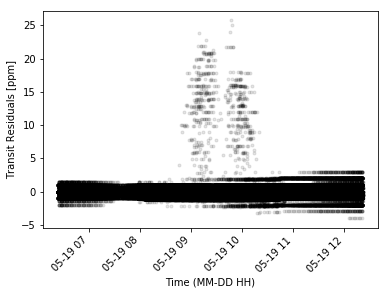

In [12]:
mf = np.median(fluxes, axis=1)

for t, f in zip(times.T, fluxes.T):    
    plt.plot_date(Time(t, format='jd').plot_date, f*1e6, fmt='.', alpha=0.1, color='k')
#plt.ylim([-0.003, 0.001])
ax = plt.gca()
ax.set(xlabel='Time (MM-DD HH)', ylabel='Transit Residuals [ppm]')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.savefig('sun_with_h11_residuals.png', bbox_inches='tight', dpi=150)